Initialize the environment

In [9]:
import torch
import argparse

print(torch.__version__)
print(torch.cuda.is_available())

2.8.0.dev20250524+cu128
True


In [7]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdocked_model/checkpoint_best.pt",
    use_conditional=False
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdocked_model/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

gpt_model/checkpoint_best.pt


Set the PDB you want to generate cmpds

In [8]:
pdb_id = "7d1m" # "5dzk, 7d1m" "7te0"
prepare_pdb_data(pdb_id,)
worker.reload_data(subset="gen_" + pdb_id.lower())

hyps, ref = worker.sample(
    m_sample=5000, 
    maxseed=30,
)

7d1m is downloaded
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7d1m.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7d1m.tg-m1.m1
| ./TamGen_Demo_Data gen_7d1m tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data/gen_7d1m.tg-m1.tg.coord


 97%|█████████▋| 29/30 [00:37<00:01,  1.28s/it]


In [10]:
from fairseq.molecule_utils.external_tools.autodock_smina import AutoDockSmina

print("Discovered binary:", AutoDockSmina.find_binary())

Discovered binary: /root/miniconda3/envs/TamGen/bin/smina


In [13]:
import os
import numpy as np
from feedback.centroid_optimizer import centroid_shift_optimize
from fairseq.molecule_utils.basic.run_docking import docking
from TamGen_Demo import TamGenDemo, prepare_pdb_data
import time

# === Setup ===
print("📦 Initializing TamGen...")
demo = TamGenDemo(
    data="TamGen_Demo_Data",
    ckpt="checkpoints/crossdocked_model/checkpoint_best.pt",
    use_conditional=True
)

pdb_id = "5ool"
print(f"📄 Preparing PDB: {pdb_id}")
prepare_pdb_data(pdb_id)
demo.reload_data(subset="gen_" + pdb_id.lower())

# === Configuration ===
NUM_ITER = 5
LATENT_DIM = 128
ALPHA = 0.5
TOP_K = 50
LAMBDA_SAS = 0.3
LAMBDA_LOGP = 0.1
LAMBDA_MW = 0.1

print("⚙️  Starting closed-loop optimization...")
for iteration in range(NUM_ITER):
    print(f"\n🚀 Iteration {iteration + 1}/{NUM_ITER}")
    start_time = time.time()

    # 1. Sampling
    print("🔍 Generating candidates...")
    results, _ = demo.sample(m_sample=100, maxseed=20)
    smiles_list = list(results.keys())
    print(f"   ✔ Generated {len(smiles_list)} molecules.")

    # 2. Latent Vectors
    print("📈 Loading latent vectors...")
    z_vectors = np.loadtxt("latent_logs/latent_vectors.tsv", delimiter="\t")
    if len(z_vectors) != len(smiles_list):
        print("⚠️  Warning: Latent vector count mismatch. Truncating to match.")
        min_len = min(len(z_vectors), len(smiles_list))
        z_vectors = z_vectors[:min_len]
        smiles_list = smiles_list[:min_len]

    # 3. Docking
    print("🧬 Running docking...")
    docking_scores = []
    for i, smi in enumerate(smiles_list):
        try:
            score = docking(pdb_id, smi)
            print(f"   [{i+1}/{len(smiles_list)}] Score = {score:.2f}")
        except Exception as e:
            print(f"   [{i+1}/{len(smiles_list)}] Docking failed: {e}")
            score = None
        docking_scores.append(score)

    # 4. Optimization
    print("📊 Optimizing latent space with centroid shift...")
    z_shifted, rewards, metrics = centroid_shift_optimize(
        z_vectors,
        smiles_list,
        docking_scores,
        latent_dim=LATENT_DIM,
        top_k=TOP_K,
        shift_alpha=ALPHA,
        lambda_sas=LAMBDA_SAS,
        lambda_logp=LAMBDA_LOGP,
        lambda_mw=LAMBDA_MW,
    )

    print("   ✔ Optimization complete.")

    # 5. Save outputs
    print("💾 Saving latent vectors and rewards...")
    os.makedirs("latent_logs", exist_ok=True)
    np.savetxt("latent_logs/latent_vectors.tsv", np.array(z_shifted), fmt="%.5f")
    with open(f"latent_logs/rewards_iter_{iteration + 1}.tsv", "w") as f:
        for smi, r in zip(smiles_list, rewards):
            f.write(f"{smi}\t{r:.4f}\n")

    print(f"✅ Completed Iteration {iteration + 1} in {time.time() - start_time:.2f} seconds")

print("\n🎉 Feedback loop finished. You may now visualize or proceed to SGDS optimization.")

📦 Initializing TamGen...
Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdocked_model/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, pre

gpt_model/checkpoint_best.pt
📄 Preparing PDB: 5ool
5ool is downloaded
| loaded 1 examples from: TamGen_Demo_Data/gen_5ool.tg-m1.tg
| loaded 1 examples from: TamGen_Demo_Data/gen_5ool.tg-m1.m1
| TamGen_Demo_Data gen_5ool tg-m1 1 examples
| loaded 1 examples from: TamGen_Demo_Data/gen_5ool.tg-m1.tg.coord
⚙️  Starting closed-loop optimization...

🚀 Iteration 1/5
🔍 Generating candidates...


 95%|█████████▌| 19/20 [00:22<00:01,  1.20s/it]


   ✔ Generated 3 molecules.
📈 Loading latent vectors...
⚠️  Warning: Latent vector count mismatch. Truncating to match.
🧬 Running docking...


stderr:




KeyboardInterrupt: 

Visualize the molecules

In [ ]:
from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem import MACCSkeys

fp_ref = MACCSkeys.GenMACCSKeys(ref)

gens = []

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens.append((v,k, similarity))

sorted_gen = sorted(gens, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(sorted_gen))])
img

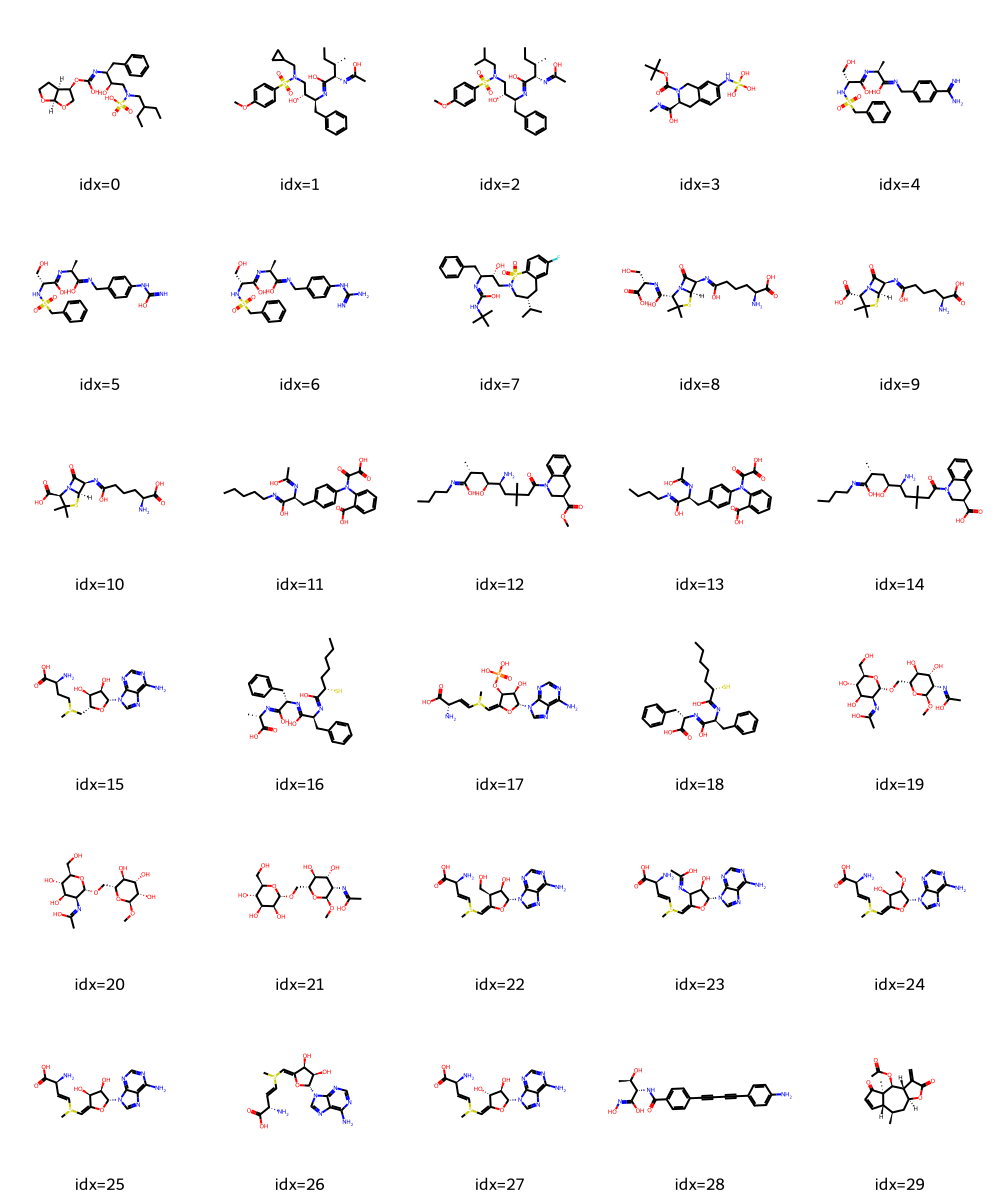

In [5]:
from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem import MACCSkeys

fp_ref = MACCSkeys.GenMACCSKeys(ref)

gens = []

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens.append((v,k, similarity))

sorted_gen = sorted(gens, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(sorted_gen))])
img

/root/miniconda3/envs/TamGen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/root/miniconda3/envs/TamGen/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


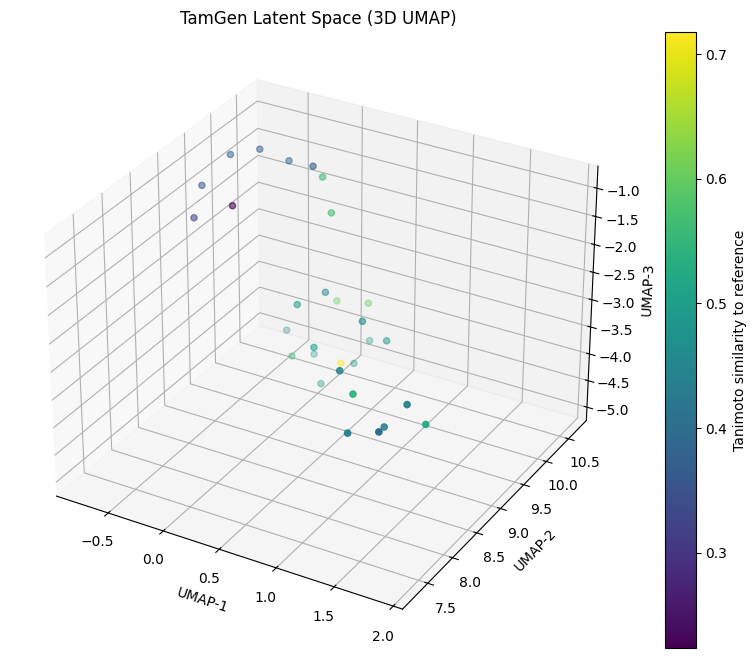

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap

# --- Load Latent Vectors ---
latent_file = "latent_logs/latent_vectors.tsv"
latent_vectors = np.loadtxt(latent_file, delimiter="\t")

# Optional: check length matches your generated molecules
if len(latent_vectors) != len(sorted_gen):
    print(f"Warning: {len(latent_vectors)} latent vectors vs {len(sorted_gen)} molecules")
    min_len = min(len(latent_vectors), len(sorted_gen))
    latent_vectors = latent_vectors[:min_len]
    sorted_gen = sorted_gen[:min_len]

# --- Project to 3D ---
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric="euclidean")
latent_3d = reducer.fit_transform(latent_vectors)

# --- Plot in 3D ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x, y, z = latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2]

colors = [entry[2] for entry in sorted_gen]  # Tanimoto similarity

p = ax.scatter(x, y, z, c=colors, cmap="viridis", s=20)
fig.colorbar(p, ax=ax, label="Tanimoto similarity to reference")
ax.set_title("TamGen Latent Space (3D UMAP)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.show()